In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# --- Load CSV ---
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
npy_dir = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"
data_df = pd.read_csv(csv_path, header=None, names=['filename', 'GID', 'GRYLD'])

type((data_df.loc[1, 'GRYLD']))
#type(row['GRYLD'])

numpy.float64

In [3]:
# --- Load all .npy images into X, yield into Y ---
X = []
Y = []

In [4]:
for idx, row in data_df.iterrows():
    npy_path = os.path.join(npy_dir, str(row['filename']))
    if os.path.exists(npy_path):
        img = np.load(npy_path)  # Already resized (145, 61, 8)
        YLD = row['GRYLD']
        X.append(img)
        Y.append(YLD)
    else:
        print(f"Warning: {npy_path} not found, skipping.")

In [5]:
X = np.array(X)
Y = np.array(Y)

print("Loaded data shape:", X.shape)  # (samples, height, width, bands)
print("Yield shape:", Y.shape)


Loaded data shape: (85855, 145, 61, 8)
Yield shape: (85855,)


In [6]:
# --- Train-test split ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Build CNN model ---
input_shape = X_train.shape[1:]  # (height, width, bands)

model = keras.Sequential([
    layers.Input(shape=input_shape),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Single regression output for grain yield
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# --- Train model ---
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 145, 61, 32)       2336      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 7, 128)        0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
import shap

# Sample a small number of background and test images
background = X_train[:500]
test_images = X_test[:100]

/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


(100, 145, 61, 8, 1)


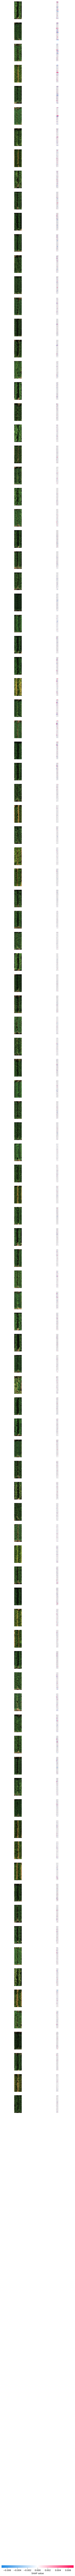

In [12]:
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_images)

print(np.array(shap_values).shape)  # (1, 10, height, width, bands)

#shap.image_plot(shap_values[0][:, :, :, :3], test_images[:, :, :, :3])

import matplotlib.pyplot as plt

i = 0  # index of image
image = test_images[i, :, :, :3]
shap_vals = shap_values[0][i, :, :, :3]

# Sum SHAP across channels for visualization (or pick one band)
shap_sum = shap_vals.sum(axis=-1)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(image / 255.0)  # normalize if needed
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(shap_sum, cmap='seismic')
plt.title("SHAP Values")
plt.colorbar()
plt.tight_layout()
plt.show()

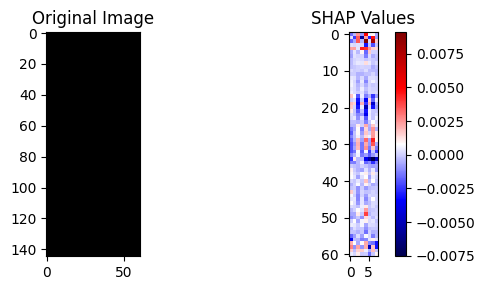

In [18]:
import matplotlib.pyplot as plt

i = 0  # index of image
image = test_images[i, :, :, :3]
shap_vals = shap_values[0][i, :, :, :3]

# Sum SHAP across channels for visualization (or pick one band)
shap_sum = shap_vals.sum(axis=-1)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(image / 255.0)  # normalize if needed
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(shap_sum, cmap='seismic')
plt.title("SHAP Values")
plt.colorbar()
plt.tight_layout()
plt.show()

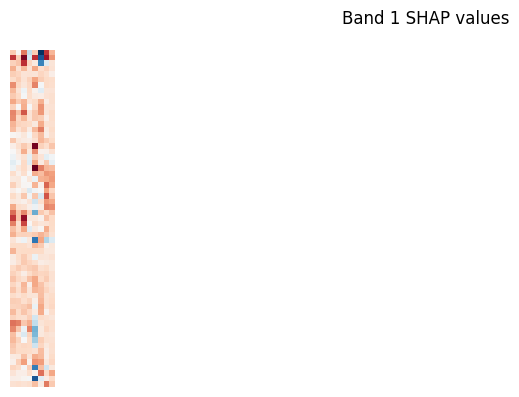

IndexError: index 1 is out of bounds for axis 3 with size 1

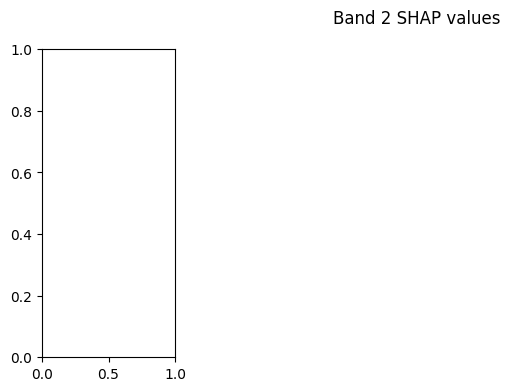

In [19]:
import matplotlib.pyplot as plt

for i in range(3):  # First 3 bands
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Band {i+1} SHAP values')
    for j in range(5):  # First 5 images
        plt.subplot(1, 5, j+1)
        plt.imshow(shap_values[0][j, :, :, i], cmap='RdBu')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# --- Evaluate ---
test_loss, test_mae = model.evaluate(X_test, Y_test)
print(f"Test MAE: {test_mae:.4f}")



537/537 [==============================] - 6s 10ms/step - loss: 0.1951 - mae: 0.3328
Test MAE: 0.3328


In [10]:
# --- Predict + check R² ---
Y_pred = model.predict(X_test).flatten()
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

537/537 [==============================] - 5s 10ms/step
R²: 0.637, RMSE: 0.442


In [11]:
model.save('CNN.h5')

In [16]:
print(f"Min: {image.min()}, Max: {image.max()}, Mean: {image.mean()}")


Min: 0.0, Max: 0.5399672985076904, Mean: 0.14588284492492676
